## Classifying a phase transition in the XXZ model

In [14]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
import qiskit.extensions.quantum_initializer as qeqi
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce
from skopt import gp_minimize
from numba import jit, njit
from copy import copy, deepcopy

import sys
sys.path.append("..")

import Entangler
import TensorNetwork
import hamiltonians
import TNOptimize
import uuid
import json
import utils

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

In [2]:
n_qubits = 10
depth = 4
depth_classifier = 6
q, c = QuantumRegister(n_qubits), ClassicalRegister(n_qubits)
ent = Entangler.IsingEntangler()
TN = TensorNetwork.Checkerboard(q, c, ent, depth=depth)
# TN_UCC = TensorNetwork.UCCSD(q, c)
TN_classifier = TensorNetwork.Checkerboard(q, c, ent, depth=depth_classifier)


tol = 1e-6
method = "L-BFGS-B"
n_max = 2**n_qubits + 100
n_cdata = 2**n_qubits
sv_b = Aer.get_backend("statevector_simulator")
qasm_b = Aer.get_backend("qasm_simulator")
unitary_b = Aer.get_backend('unitary_simulator')

### Loading the data

The data set contains the rows where first 1024 entries are the wavefunction, next 100 are the parameters, then the Jz parameter, energy, and label

In [3]:
small_data = "vqe_2019-04-30_10-30-02.csv"
bigger_data = "vqe_2019-05-06_16-16-53.csv"
gpu_data = "vqe_GPU_2019-05-28_13-28-07.csv"
filename = bigger_data


df_vqe_2 = pd.read_csv(filename, header=None)
df_vqe_2 = df_vqe_2.applymap(lambda x: np.complex(x))

df_vqe_2[n_max] = df_vqe_2[n_max].apply(lambda x: x.real)
df_vqe_2[n_max+1] = df_vqe_2[n_max+1].apply(lambda x: x.real)
df_vqe_2[n_max+2] = df_vqe_2[n_max+2].apply(lambda x: x.real)

# df_vqe = df_vqe_2.drop([0, 1])
df_vqe = df_vqe_2

### Cleaning the data

In [4]:
df_vqe_clean = df_vqe.sort_values(by=[n_max])
df_vqe_clean.index = np.arange(len(df_vqe))
# df_vqe_clean = df_vqe.sort_index(by=[n_max])

todrop = []
tokeep = []
for i in range(len(df_vqe) // 2):
    E_1 = df_vqe_clean.iloc[i * 2, n_max + 1]
    E_2 = df_vqe_clean.iloc[i * 2 + 1, n_max + 1]
    h_1 = df_vqe_clean.iloc[i * 2, n_max]
    h_2 = df_vqe_clean.iloc[i * 2 + 1, n_max]
#     print(h_1, h_2)
#     print(E_1, E_2)
#     print("====")
    if (E_2 > E_1):
        todrop.append(i * 2 + 1)
        tokeep.append(i * 2)
    else:
        todrop.append(i * 2)
        tokeep.append(i * 2 + 1)

        
for i in range(len(df_vqe) // 2):
    E_kept = df_vqe_clean.iloc[tokeep[i], n_max + 1]
    E_dropped = df_vqe_clean.iloc[todrop[i], n_max + 1]
    if E_dropped < E_kept:
        print("AAA")

print(df_vqe_clean.iloc[:20, [n_max, n_max + 1]])

print(todrop[:10])
print(tokeep[:10])

print("=============")        
        
df_vqe_clean = df_vqe_clean.drop(todrop)
print(df_vqe_clean.iloc[:10, [n_max, n_max + 1]])

     1124       1125
0   0.000 -12.437153
1   0.000 -12.436953
2   0.002 -12.444505
3   0.002 -12.444670
4   0.004 -12.452185
5   0.004 -12.452063
6   0.006 -12.459702
7   0.006 -12.459627
8   0.008 -12.467196
9   0.008 -12.467222
10  0.010 -12.474770
11  0.010 -12.474745
12  0.012 -12.482349
13  0.012 -12.482272
14  0.014 -12.489932
15  0.014 -12.489803
16  0.016 -12.497519
17  0.016 -12.497337
18  0.018 -12.504877
19  0.018 -12.505016
[1, 2, 5, 7, 8, 11, 13, 15, 17, 18]
[0, 3, 4, 6, 9, 10, 12, 14, 16, 19]
     1124       1125
0   0.000 -12.437153
3   0.002 -12.444670
4   0.004 -12.452185
6   0.006 -12.459702
9   0.008 -12.467222
10  0.010 -12.474770
12  0.012 -12.482349
14  0.014 -12.489932
16  0.016 -12.497519
19  0.018 -12.505016


In [5]:
len(df_vqe_clean)

1000

### Augmenting the data

#### Flips

First I am going to flip the spins along the X direction. Then for each of the data points I will also add a random Z rotation.

In [6]:
df_flip = df_vqe_clean.copy()
# df_flip = df_vqe.copy()
df_flip.index = np.arange(len(df_flip))


In [7]:
## hardcoded for 10 qubits and depth 4
z_gate_indices = [74 + i * 5 + k for i in range(5) for k in (4, 5)]
x_gate_indices = [74 + i * 5 + k for i in range(5) for k in (1, 2)]

In [8]:
for n in z_gate_indices:
    df_flip[2**n_qubits + n] *= -1

for n in x_gate_indices:
    df_flip[2**n_qubits + n] += np.pi

In [9]:
wavefun_cols_order = list(reversed(range(1024)))
cols_order = wavefun_cols_order + list(range(1024, n_max + 3))
df_flip = df_flip.reindex(columns=cols_order)

To check the correctness of the flip operation, I will now check that the wavefunction, ansatz parameters and the energy are consistent

In [10]:
h_0 = hamiltonians.xxz_heisenberg_model(10, 1, 0)
h_1 = hamiltonians.xxz_heisenberg_model(10, 0, 1)
H_0 = hamiltonians.explicit_hamiltonian(h_0)
H_1 = hamiltonians.explicit_hamiltonian(h_1)

energy_off = False
statebuilding_error = False

for i, row in df_flip.iterrows():
#     if i>5:
#         break
        
    state = np.array(row[:2**n_qubits])
    E = row[n_max + 1].real
    h = row[n_max].real
    E_fact = (state.conj() @ (H_0 + h * H_1) @ state).real
    if not(np.isclose(E, E_fact)):
        print("Found energy error in row {}".format(i))
        energy_off = True
        
    params = np.array(row[2**n_qubits : 2**n_qubits + 100])    
    circ = TN.construct_circuit(params)
    state_built = utils.get_state(circ)
#     print(abs(state_built.conj() @ state))
#     print(np.linalg.norm(state))
#     print(np.linalg.norm(state_built))
#     print("====")
    product = abs(state_built.conj() @ state)
    if not(np.isclose(product, 1)):
        print("Found state vs params error in row {}".format(i))
        statebuilding_error = True

        
if (not energy_off and not statebuilding_error):
    print("All OK")

/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshm

KeyboardInterrupt: 

In [ ]:
df_with_flip = df_vqe.append(df_flip)
# df_with_flip = df_vqe_clean.append(df_flip)
len(df_with_flip)

#### Angles

In [ ]:
df_rotated = df_with_flip.copy()
df_rotated.index = np.arange(len(df_rotated))


In [ ]:
### change the params by adding random angles to params

for i in range(len(df_rotated)):
    angle = 2 * np.pi * np.random.rand()
    for n in z_gate_indices:
        df_rotated.iloc[i, 2**n_qubits + n] += angle

In [14]:
## construct new states based on the params provided (not a good solution really)

for i in range(len(df_rotated)):
    params = np.array(df_rotated.iloc[i, 2**n_qubits:(2**n_qubits + TN.n_params)])
    circ = TN.construct_circuit(params)
    state_built = utils.get_state(circ)
    h = df_rotated.iloc[i, n_max]
    E_built = (state_built.conj() @ (H_0 + h * H_1) @ state_built).real
    E = df_rotated.iloc[i, n_max + 1]
    if not (np.isclose(E, E_built)):
        print('Error')
    df_rotated.iloc[i, :2**n_qubits] = state_built


In [15]:
# i = 150
# params = np.array(df_rotated.iloc[i, 2**n_qubits:(2**n_qubits + TN.n_params)])
# circ = TN.construct_circuit(params)
# state_built = utils.get_state(circ)
# E = df_rotated.iloc[i, n_max + 1]
# print(E)
# h = df_rotated.iloc[i, n_max]
# E_built = (state_built.conj() @ (H_0 + h * H_1) @ state_built).real
# print(E_built)
# state = np.array(df_rotated.iloc[i, :2**n_qubits])




In [16]:
df_total = df_with_flip.append(df_rotated)
df_total.index = np.arange(len(df_total))


In [3]:
#### Save the total database just in case

df_total.to_csv(path_or_buf="df_total_bigger.csv", index=False, header=None)

NameError: name 'df_total' is not defined

In [18]:
df = df_total.copy()
len(df_total)

5580

### Reload the prepared dataset if you don't want to build it

In [4]:
### Load if necessary

df_total = pd.read_csv("df_total_bigger.csv", header=None)
print(len(df_total))
df_total = df_total.applymap(lambda x: np.complex(x))

df_total[n_max] = df_total[n_max].apply(lambda x: x.real)
df_total[n_max+1] = df_total[n_max+1].apply(lambda x: x.real)
df_total[n_max+2] = df_total[n_max+2].apply(lambda x: x.real)


4000


### Split the data into train and test

In [5]:
df_shuffled = df_total.sample(frac=1).reset_index(drop=True)
train_pos = int(0.8 * len(df_total))
df_train = df_shuffled.iloc[:train_pos,:]
df_test = df_shuffled.iloc[train_pos:,:]

### Constructing objective functions

In [6]:
def count_ones(x):
    count = 0
    x_c = copy(x)
    while x_c != 0:
        x_c = x_c & (x_c-1)
        count += 1
    return count


# @jit
def unitary_prediction(state, U):
    """Returns the probability that the state is in class II by
    transforming the circuit into a unitary map"""
#     if U_supply is None:
#         result = execute(NN_circ, unitary_b).result()
#         U = result.get_unitary(NN_circ)
#     else:
#         U = U_supply
    res_state = U @ state
    
    label = [0, 0]
    
    for i in range(len(res_state)):
        qty_ones = count_ones(i)
        if qty_ones > n_qubits // 2:
            label[1] += abs(res_state[i])**2
        elif qty_ones < n_qubits // 2:
            label[0] += abs(res_state[i])**2 / 2 

    return label[1] / (label[0] + label[1])

def build_loss_fun(df, start, batch_size, TN_classifier):
    """construct the loss function for a batch"""
#     if (finish <= start):
#         raise ValueError("Specify other rows")
    if batch_size < 1:
        raise ValueError("Invalid batch size")
    #indices = np.random.choice(len(df), batch_size, replace=False)
    #indices = np.arange(start, start + batch_size)
    

    def f(x):
        circ = TN_classifier.construct_circuit(x)
        result = execute(circ, unitary_b).result()
        U = result.get_unitary(circ)
        logloss = 0
        for i in range(start, start+batch_size):
            state = np.array(df_train.iloc[i][:n_cdata])
            y = df_train.iloc[i][n_max+2].real
            p = unitary_prediction(state, U)
            logloss += -(y * np.log(p) + (1 - y) * np.log(1 - p))
            
        return logloss / batch_size
    return f

# @jit
def rand_grad(x, f, eps):
    dx = np.random.randn(np.shape(x)[0]) * eps
    f_plus = f(x + dx)
    f_minus = f(x - dx)
    return (f_plus - f_minus) / 2 / dx, 0.5 * (f_plus + f_minus)

In [7]:
count_ones(71)

4

### Running the machine learning

In [8]:
len(df_train)

3200

In [23]:
%%time
batch_size = 1600
n_epochs = 300

losses = []


params = np.random.rand(TN_classifier.n_params) - 0.5
x = params

lr_base = 5

decay = 1e-3
factor = 1 - decay

eps_base = 5e-2

v = np.zeros(TN_classifier.n_params) #momentum

for epoch in range(n_epochs):
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    for batch_num in range(len(df_train) // batch_size):
        
        start = batch_size * batch_num
        f = build_loss_fun(df_train, start, batch_size, TN_classifier)
        #res = minimize(f, x, options={'maxiter':3}, method="L-BFGS-B")
        
        eps = eps_base / (1 + batch_num * (epoch + 1))**0.5
        lr = lr_base / (1 + batch_num * (epoch + 1))**0.5
        
        #grad = approx_fprime(x, f, eps)
        dx = np.random.randn(np.shape(x)[0]) * eps
        f_plus = f(x + dx)
        f_minus = f(x - dx)
        
        grad = (f_plus - f_minus) / 2 / np.linalg.norm(dx)
                                
        v = 0.9 * v - grad * lr * dx
        x = x + v        
        
        loss = (f_plus + f_minus) / 2
        if (epoch % 20 == 0 or epoch < 15):
            print('Epoch {0:d} batch {1:d}'.format(epoch, batch_num))
            print('loss:', loss)
        losses.append(loss)

Epoch 0 batch 0
loss: 0.6830058247558857
Epoch 0 batch 1
loss: 0.6423018426370497
Epoch 1 batch 0
loss: 0.6579256463634271
Epoch 1 batch 1
loss: 0.6250625693999448
Epoch 2 batch 0
loss: 0.6060393734811802
Epoch 2 batch 1
loss: 0.6194685139880189
Epoch 3 batch 0
loss: 0.6051817897603731
Epoch 3 batch 1
loss: 0.5785070141434753
Epoch 4 batch 0
loss: 0.5638172578290552
Epoch 4 batch 1
loss: 0.5626275715407014
Epoch 5 batch 0
loss: 0.5548592295208545
Epoch 5 batch 1
loss: 0.5559801466251628
Epoch 6 batch 0
loss: 0.5482941212638734
Epoch 6 batch 1
loss: 0.5392586282490843
Epoch 7 batch 0
loss: 0.5742099593734049
Epoch 7 batch 1
loss: 0.5387715810036922
Epoch 8 batch 0
loss: 0.5434375397875996
Epoch 8 batch 1
loss: 0.5368603285824706
Epoch 9 batch 0
loss: 0.5760954191254464
Epoch 9 batch 1
loss: 0.5274557287847788
Epoch 10 batch 0
loss: 0.5387804717076128
Epoch 10 batch 1
loss: 0.5443966543424906
Epoch 11 batch 0
loss: 0.5326585149325189
Epoch 11 batch 1
loss: 0.5541620073141511
Epoch 12 bat

In [9]:
x = [-1.02335802e+00,  2.31935568e-01,  2.17377158e-01, -6.81614619e-02,
        4.49976668e-01, -1.25318105e+00, -1.57964488e-03, -2.27268290e-01,
        1.32409502e+00,  2.14893641e-01, -5.22625057e-01, -9.11044073e-01,
       -5.48203198e-01,  1.25764768e+00,  1.00296749e-01,  3.89367060e-01,
        7.40472455e-01,  1.12086803e+00, -1.84506560e+00, -7.33417250e-02,
        1.14967871e+00,  3.79769082e-01, -9.36844213e-01,  1.40353063e+00,
       -2.19027977e-01, -6.96792624e-01,  6.93078162e-01,  9.71494906e-01,
        1.19778934e+00,  3.09460149e-01,  4.93264160e-01,  6.25002429e-02,
       -4.37182014e-01, -2.32435502e-01,  1.63023837e+00,  4.28949364e-01,
        8.12777173e-01, -5.31482587e-01,  1.04330143e-01, -1.25729577e-02,
       -7.14033363e-02, -1.37354019e-01, -2.05588494e-02, -3.79656557e-01,
        7.73474217e-01,  1.19031591e+00,  7.70088541e-01, -4.10207502e-02,
       -1.36172783e+00,  5.57214624e-01, -4.39333748e-01, -1.10700613e+00,
       -1.33029019e+00,  4.65223482e-01, -1.01198649e+00,  1.45909694e-02,
        3.15443049e-01,  1.63117584e-01, -3.15171773e-02,  4.89690524e-01,
       -1.73558305e+00, -7.74783388e-01, -2.63520690e-02, -4.54009561e-01,
       -9.76754999e-01, -1.27976648e+00,  9.20149649e-01,  8.60648979e-01,
       -4.35370428e-01,  1.55543672e-01,  1.34208007e+00, -2.09292972e-01,
        1.18392073e-01,  3.95509335e-01,  3.61183608e-01,  5.97618039e-01,
        2.86537880e-02, -1.98185212e-02,  1.21660435e+00, -7.47554113e-01,
       -6.26976819e-01, -6.41667560e-01, -5.96422632e-01,  6.26299895e-01,
       -4.41809815e-01, -5.11445778e-02,  5.62485341e-01, -1.44338678e-01,
       -1.36767500e-01, -2.29000824e-01, -7.89304240e-01, -1.19940778e+00,
       -5.82305024e-02,  2.52405506e-01,  1.13629954e-01, -6.10055374e-01,
       -2.28418342e-02,  7.55102072e-01, -8.35228199e-01,  3.87976591e-01,
        1.24700929e-01, -7.81910001e-02,  1.29876376e+00, -3.20282284e-01,
        2.96956522e-01,  1.06814585e+00, -1.09121499e+00, -1.63690087e+00,
       -1.19381605e+00,  1.91203921e+00, -3.80589902e-01,  1.42906317e+00,
        5.07096986e-02, -7.55216186e-02, -8.90204040e-01, -5.81672946e-01,
       -6.32359503e-01,  1.16466396e+00,  4.24127799e-01,  2.25584872e-02,
       -6.09641241e-01,  6.36438887e-01,  8.55999266e-02, -4.01963350e-01,
       -9.11083997e-01, -9.12579329e-01, -8.32870462e-01,  2.69213718e-01,
        4.18729734e-01,  1.09870101e-01, -6.18246778e-02, -8.34339282e-01,
       -1.10284888e+00,  6.62339190e-02, -9.21501073e-01,  3.32683230e-01,
        2.14645379e-01,  2.97981584e-01, -1.17363417e+00,  7.59263883e-02,
       -2.26173526e-01,  3.09249814e-01, -3.86584187e-01, -1.73685261e+00,
       -9.19339652e-01, -9.31940038e-01, -8.34326261e-01, -1.21979081e+00,
        8.39923204e-02, -3.22979066e-01]

### Checking the performance on the test set

In [10]:
%matplotlib inline

NN_circ = TN_classifier.construct_circuit(x)
preds = []
trues = np.array(df_test[n_max + 2])
result = execute(NN_circ, unitary_b).result()
U = result.get_unitary(NN_circ)
for i in range(len(df_test)):
    state = df_test.iloc[i][:n_cdata]
    preds.append(unitary_prediction(state, U))
    

# plt.rcParams.update({'font.size': 14})


# plt.figure()
# fields = np.array(df_test[n_max])
# plt.scatter(fields, preds)

# plt.xlabel(r'$J_z$')
# plt.ylabel('Prediction of label II')
# plt.grid()
# plt.ylim([0, 1])
# plt.xlim([0, 2])
# plt.plot([1, 1], [0, 1], 'r')
# plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
# plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
# plt.plot([0, 2], [0.5, 0.5], 'r--')
# plt.show()

/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


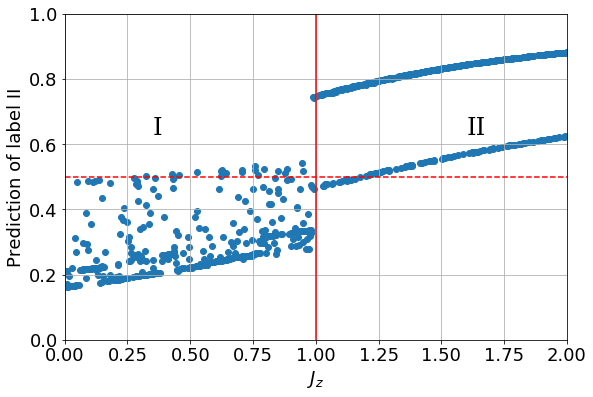

In [15]:
# %matplotlib inline
# plt.rcParams.update({'font.size': 14})
# plt.figure()
fields = np.array(df_test[n_max])
plt.scatter(fields, preds)

plt.xlabel(r'$J_z$')
plt.ylabel('Prediction of label II')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 2])
plt.plot([1, 1], [0, 1], 'r')
plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
plt.plot([0, 2], [0.5, 0.5], 'r--')
plt.show()

In [16]:
correct = 0
for i, p in enumerate(preds):
    if abs(trues[i] - p) < 0.5:
        correct += 1
print(correct / len(df_test))

0.94875
